### Dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

In [59]:
import cv2
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns
from sklearn.model_selection import train_test_split

GEN_DATA=True

In [8]:
directories = [
    'Dataset/yes',
    'Dataset/no'
]

def process_images(directory, image_set_name, target_size=(240, 240)):
    image_data = []


    for file_name in os.listdir(directory):
        if file_name.endswith(('.jpg', '.jpeg')):
            file_path = os.path.join(directory, file_name)
            
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Could not read {file_name}. Skipping.")
                continue
            
            _, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
     
                x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                cropped_img = img[y:y+h, x:x+w]
                resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)
                image_data.append(resized_img)
                
            else:
                print(f"No content found in {file_name}. Skipping.")


    image_data = np.array(image_data)

    np.save(f'{directory}/{image_set_name}.npy', image_data)
    print(f"Saved cropped and resized images to {directory}/{image_set_name}.npy")

process_images('Dataset/yes', "yes")
process_images('Dataset/no', "no")

Saved cropped and resized images to Dataset/yes/yes.npy
Saved cropped and resized images to Dataset/no/no.npy


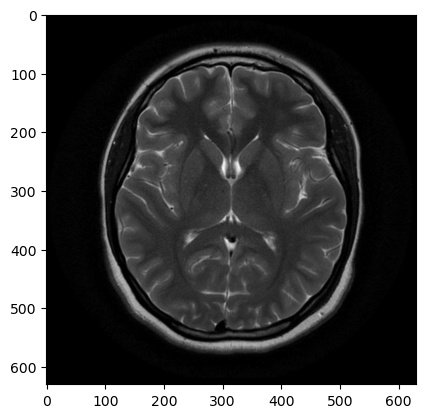

In [73]:
img = cv2.imread('Dataset/Original/no/1 no.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

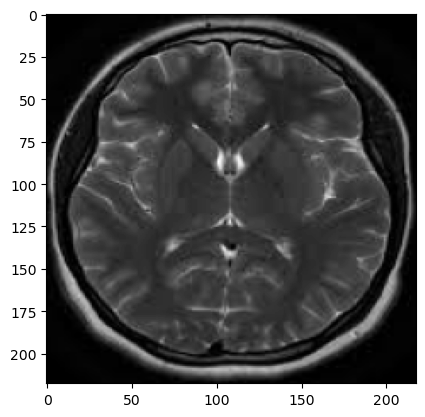

In [72]:
abnormal = np.load('Dataset/no/no.npy')

plt.imshow(abnormal[0], cmap='gray')

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

class ConvNet(nn.Module):
    
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 120)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def np_to_torchLoader(images_np, labels_np, batchSize):
    images_torch = np.array(images_np)
    labels_torch = np.array(labels_np)

    images_tensor = torch.Tensor(images_torch).unsqueeze(1)
    labels_tensor = torch.Tensor(labels_torch).type(torch.LongTensor)

    DataSet = TensorDataset(images_tensor, labels_tensor)
    Loader = DataLoader(DataSet, batch_size=batchSize)
    return Loader

def trainCNN(images_np, labels_np, test_np, test_labels_np, numImages=10000000, 
             num_classes=2, epochs=20):
    
    images_np = images_np[0:numImages]
    labels_np = labels_np[0:numImages]
    
    convNet = ConvNet(num_classes)
    
    percentCorrectPerEpochTrain = []
    percentCorrectPerEpochTest = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)
    loss = 1

    for epoch in range(epochs):
        loader = np_to_torchLoader(images_np, labels_np, 256)
        running_loss = 0.0
        for i, data in enumerate(loader):

            inputs, labels = data
            
            optimizer.zero_grad()
   
            outputs = convNet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      
            if i % 255 == 0:  
                print(f'Epoch {epoch+1} loss: {running_loss / 256 :.7f}')
                loss = running_loss / 256
 
            running_loss = 0.0
        
        loader = np_to_torchLoader(images_np, labels_np, 1)
        train_accuracy, _, _ = testCNN(convNet, loader, num_classes)
        loader = np_to_torchLoader(test_np, test_labels_np, 1)
        test_accuracy, _, _ = testCNN(convNet, loader, num_classes)
        percentCorrectPerEpochTrain.append(train_accuracy)
        percentCorrectPerEpochTest.append(test_accuracy)
        
    print('Finished Training')

    return convNet, percentCorrectPerEpochTrain, percentCorrectPerEpochTest

def testCNN(convNet, loader, num_classes):
    wrongly_classified = {}
    confusion_mat = np.zeros((num_classes, num_classes))
    numCorrect = 0
    dataiter = iter(loader)
    for image, label in dataiter:
        yhat = convNet(image)
        _, predicted = torch.max(yhat, 1)
        if predicted == label: 
            numCorrect += 1
        elif predicted[0].item() in wrongly_classified:
            wrongly_classified[predicted[0].item()].append((image, label[0].item()))
        else:
            wrongly_classified[predicted[0].item()] = [(image, label[0].item())]
        
        confusion_mat[label, predicted] += 1
            
    return numCorrect/len(dataiter), wrongly_classified, confusion_mat

def plot_accuracy_per_epoch(epochs, train, test, title):
    plt.figure(figsize=(6, 6))
    plt.plot(range(1, epochs+1), train, label = "Train Accuracy Over Epochs")
    plt.plot(range(1, epochs+1), test, label = "Validation Accuracy Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

In [56]:
abnormal = np.load('Dataset/yes/yes.npy')
normal = np.load('Dataset/no/no.npy')
abnormal_labels = np.zeros(len(normal)) 
normal_labels = np.ones(len(abnormal)) 


images = np.concatenate([abnormal, normal], axis=0)
labels = np.concatenate([abnormal_labels, normal_labels], axis=0)


images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=42)

In [57]:
convNet, percentCorrectPerEpochTrain, percentCorrectPerEpochTest = trainCNN(images_train, 
                                                                            labels_train, 
                                                                            images_test,
                                                                            labels_test,
                                                                            epochs=50)

Epoch 1 loss: 0.0055547
Epoch 2 loss: 0.0033995
Epoch 3 loss: 0.0048563
Epoch 4 loss: 0.0040535
Epoch 5 loss: 0.0029517
Epoch 6 loss: 0.0033609
Epoch 7 loss: 0.0033184
Epoch 8 loss: 0.0029330
Epoch 9 loss: 0.0027714
Epoch 10 loss: 0.0028080
Epoch 11 loss: 0.0028175
Epoch 12 loss: 0.0027069
Epoch 13 loss: 0.0025718
Epoch 14 loss: 0.0025246
Epoch 15 loss: 0.0025346
Epoch 16 loss: 0.0025393
Epoch 17 loss: 0.0024990
Epoch 18 loss: 0.0024380
Epoch 19 loss: 0.0023950
Epoch 20 loss: 0.0023824
Epoch 21 loss: 0.0023778
Epoch 22 loss: 0.0023568
Epoch 23 loss: 0.0023178
Epoch 24 loss: 0.0022864
Epoch 25 loss: 0.0022763
Epoch 26 loss: 0.0022705
Epoch 27 loss: 0.0022506
Epoch 28 loss: 0.0022167
Epoch 29 loss: 0.0021841
Epoch 30 loss: 0.0021636
Epoch 31 loss: 0.0021454
Epoch 32 loss: 0.0021166
Epoch 33 loss: 0.0020826
Epoch 34 loss: 0.0020550
Epoch 35 loss: 0.0020337
Epoch 36 loss: 0.0020107
Epoch 37 loss: 0.0019840
Epoch 38 loss: 0.0019594
Epoch 39 loss: 0.0019387
Epoch 40 loss: 0.0019176
Epoch 41 

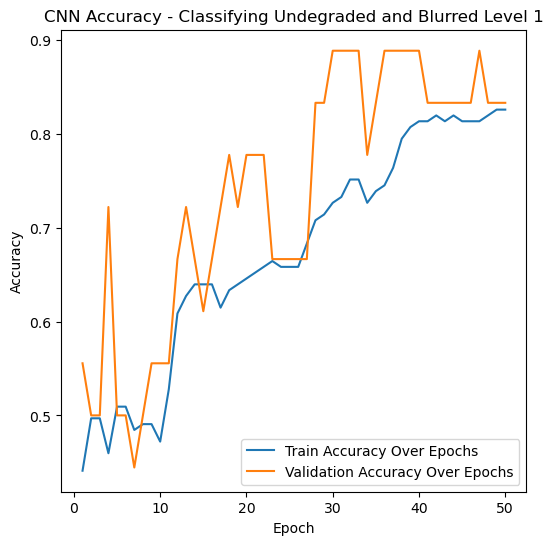

In [58]:
plot_accuracy_per_epoch(50, percentCorrectPerEpochTrain, percentCorrectPerEpochTest, 
                        "CNN Accuracy - Classifying Undegraded and Blurred Level 1")